# Small Data Science for Insurance Example

### Adopted from [Randal S. Olson](http://www.randalolson.com/) (edited by ASKS Data Science Group)
#### Supported by [THRES]

## Table of contents

1. [License](#License)

2. [Step 1: The question](#Step-1:-Understanding-the-)

3. [Step 2: Checking the data](#Step-2:-Checking-the-data)

4. [Step 3: Preparing the data](#Step-3:-Preparing-the-data)

5. - [Testing our data](#Bonus:-Testing-our-data)

6. [Step 4: Exploratory analysis](#Step-4:-Exploratory-analysis)

7. [Step 5: Classification](#Step-5:-Classification)

    - [Cross-validation](#Cross-validation)

    - [Parameter tuning](#Parameter-tuning)

8. [Step 6: Reproducibility](#Step-6:-Reproducibility)

9. [Further reading](#Further-reading)


## License

Please see the original [repository README file](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects#license) for the licenses and usage terms for the instructional material and code in this notebook. I cloned and then edited it from the original authors. For any further usage, please follows them.

## Step 1: The question

For this example, you should imagine that you work on an insurance company, ASKS Insurance Inc. The company has bought out an insurance company which took a heavy losses. One of the reasons was its health insurance packages. It had too many customers with high risk of incurring medical expenses. As such, you are asked to find out a way to predict which future customer, we should ask for a higher pay. 

For the data science project, as in any other project, we begin by defining the problem, and the measurement for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that, so let's work through those questions.

>Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

We're trying to classify the medical-risk-level (i.e., class) of the customered based on provided data.

>Did you define the metric for success before beginning?

Let's do that now. Since we're performing classification, we can use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) — the fraction of correctly classified customers — to quantify how well our model is performing. Our company's Head of Data has told us that we should achieve at least 90% accuracy.

>Did you understand the context for the question and the scientific or business application?

We're building part of a data analysis pipeline for a smartphone app that will be able to classify the medical-risk of customer from the data entered via the smartphone.

>Did you record the experimental design?

Our company's Head of Data has told us that the sampled data was taken from the previous customer records of company we took over. The customer information that they provided contain the age, sex, bmi, children, smoker, region, and actual charges. At the end of each day, the data is compiled and stored in a csv file. They want you to label the data for them too. If charge <= 10000, 10000 < charge <= 20000, and charge >= 20000, the customer is considered as "LOW", "MID", and "HIGH" risk respectively. 

>Did you consider whether the question could be answered with the available data?

The data set we currently have is only for a portion of the real customer, and only have a few levels. The model built off of this data set will not be an accurate predictor for the real risk modeling.

<hr />

Notice that we've spent a fair amount of time working on the problem without writing a line of code or even looking at the data.

**Thinking about and documenting the problem we're working on is an important step to performing effective data analysis that often goes overlooked.** Don't skip it.

## Step 2: Checking the data

The next step is to look at the data we're working with. Even curated data sets from the government can have errors in them, and it's vital that we spot these errors before investing too much time in our analysis.

Generally, we're looking to answer the following questions:

* Is there anything wrong with the data?
* Are there any quirks with the data?
* Do I need to fix or remove any of the data?

Let's start by reading the data into a pandas DataFrame.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

insurance_data = pd.read_csv('../data/insurance.csv')
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,middle,16884.92400
1,18,male,33.770,1,no,south,1725.55230
2,28,male,33.000,3,no,south,4449.46200
3,33,male,22.705,0,no,north,21984.47061
4,32,male,28.880,0,no,north,3866.85520


**One of the first things we should look for is missing data.** Thankfully, the field researchers already told us that they put a 'NA' into the spreadsheet when they were missing a measurement.

We can tell pandas to automatically identify missing values if it knows our missing value marker.

In [2]:
insurance_data = pd.read_csv('../data/insurance.csv', na_values=['NA'])

The above line tell pandas to treat rows with 'NA' as missing values.

Next, we look at the distribution of our data by printing out some summary statistics about the data set.


In [3]:
insurance_data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,south,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


What do you see here? Do you think it is useful?

In [4]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

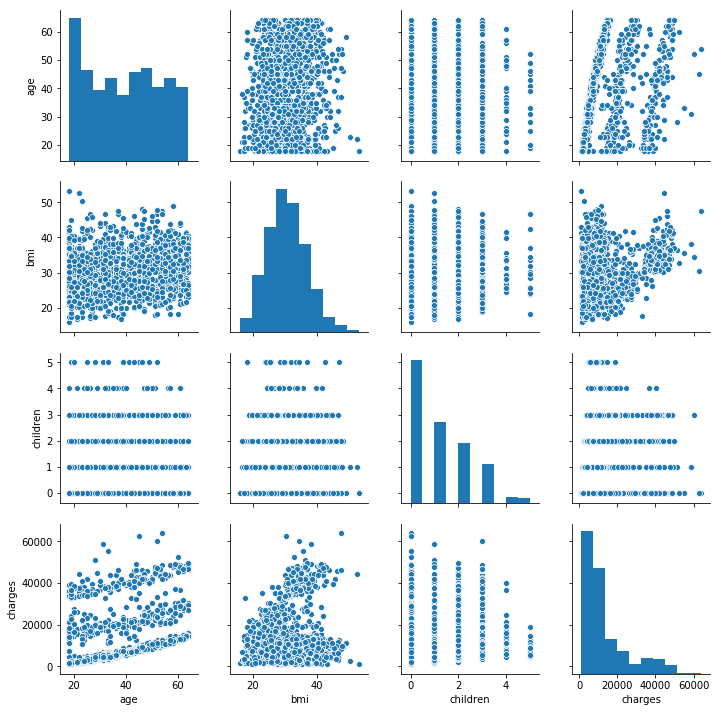

In [5]:
# We have to temporarily drop the rows with 'NA' values
# because the Seaborn plotting function does not know
# what to do with them
insurance_df = insurance_data.dropna();
sb.pairplot(insurance_df);

From the scatterplot matrix, what do you see?


## Step 3: Preparing the data

Now that we've looked at the data set, we need to prepare them before we proceed with the analysis.

Let's use the DataFrame to construct the label for the risk level.

In [6]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
insurance_df["sex_code"] = lb_make.fit_transform(insurance_df["sex"])
insurance_df[["sex", "sex_code"]].head(11)

,sex,sex_code
0,female,0
1,male,1
2,male,1
3,male,1
4,male,1
5,female,0
6,female,0
7,female,0
8,male,1
9,female,0


In [7]:
insurance_df["smoker_code"] = lb_make.fit_transform(insurance_df["smoker"])
insurance_df["region_code"] = lb_make.fit_transform(insurance_df["region"])
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code
0,19,female,27.900,0,yes,middle,16884.92400,0,1,0
1,18,male,33.770,1,no,south,1725.55230,1,0,3
2,28,male,33.000,3,no,south,4449.46200,1,0,3
3,33,male,22.705,0,no,north,21984.47061,1,0,1
4,32,male,28.880,0,no,north,3866.85520,1,0,1


What about other outliers? Did we notice?

Fixing outliers can be tricky. It's rarely clear whether the outlier was caused by measurement error, recording the data in improper units, or if the outlier is a real anomaly. For that reason, we should be judicious when working with outliers: if we decide to exclude any data, we need to make sure to document what data we excluded and provide solid reasoning for excluding that data. (i.e., "This data didn't fit my hypothesis" will not stand peer review.)

From the previous plot, we notice that there are customers with charges > 60,000. But, the maximum payout of the current plan is 60,000. Let us see who they are.

In [8]:
insurance_df.loc[insurance_df['charges'] > 60000]

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code
543,54,female,47.410,0,yes,south,63770.42801,0,1,3
1230,52,male,34.485,3,yes,north,60021.39897,1,1,1
1300,45,male,30.360,0,yes,south,62592.87309,1,1,3


Then, we will drop them. And check that we have dropped them

In [9]:
insurance_df = insurance_df.loc[insurance_df['charges'] <= 60000];
insurance_df.loc[insurance_df['charges']> 60000]

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code


Excellent! Now all of our rows have charge within the boundary. Now we are required to have three class types.

In [10]:
insurance_df["risk_level"] = pd.cut(insurance_df["charges"],bins=[0,15000,30000,60000],right=True,labels=["LOW", "MID", "HIGH"])
insurance_df.head(20)

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code,risk_level
0,19,female,27.900,0,yes,middle,16884.92400,0,1,0,MID
1,18,male,33.770,1,no,south,1725.55230,1,0,3,LOW
2,28,male,33.000,3,no,south,4449.46200,1,0,3,LOW
3,33,male,22.705,0,no,north,21984.47061,1,0,1,MID
4,32,male,28.880,0,no,north,3866.85520,1,0,1,LOW
5,31,female,25.740,0,no,south,3756.62160,0,0,3,LOW
6,46,female,33.440,1,no,south,8240.58960,0,0,3,LOW
7,37,female,27.740,3,no,north,7281.50560,0,0,1,LOW
8,37,male,29.830,2,no,northeast,6406.41070,1,0,2,LOW
9,60,female,25.840,0,no,north,28923.13692,0,0,1,MID


Next, let's drop the old columns out

In [11]:
insurance_clean = insurance_df.drop(columns=['sex','smoker','region','charges'])
insurance_clean.head()

,age,bmi,children,sex_code,smoker_code,region_code,risk_level
0,19,27.900,0,0,1,0,MID
1,18,33.770,1,1,0,3,LOW
2,28,33.000,3,1,0,3,LOW
3,33,22.705,0,1,0,1,MID
4,32,28.880,0,1,0,1,LOW


Now, let's take a look at the scatterplot matrix now that we've tidied the data.

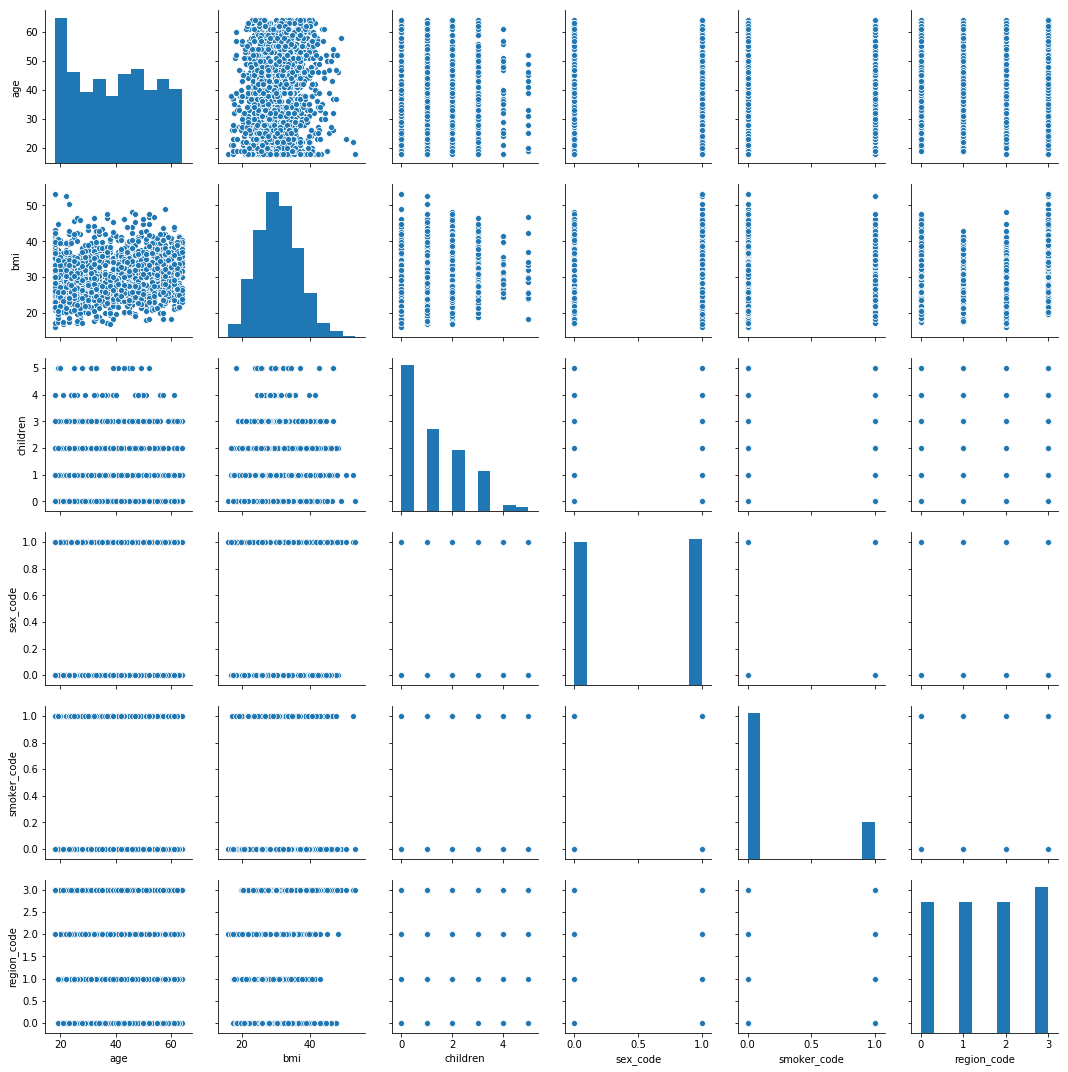

In [12]:
sb.pairplot(insurance_clean);

The general takeaways here should be:

* Make sure your data is encoded properly

* Make sure your data falls within the expected range, and use domain knowledge whenever possible to define that expected range

* Deal with missing data in one way or another: replace it if you can or drop it

* Never tidy your data manually because that is not easily reproducible

* Use code as a record of how you tidied your data

* Plot everything you can about the data at this stage of the analysis so you can *visually* confirm everything looks correct

Let us save our clean data for future reference.

In [13]:
insurance_clean.to_csv('../data/insurance_clean.csv')

## Good Practice: Testing the data

Just like how we use unit tests to verify our expectations from code, we can similarly set up unit tests to verify our expectations about a data set.

We can quickly test our data using `assert` statements: We assert that something must be true, and if it is, then nothing happens and the notebook continues running. However, if our assertion is wrong, then the notebook stops running and brings it to our attention. For example,

```Python
assert 1 == 2
```

will raise an `AssertionError` and stop execution of the notebook because the assertion failed.

Let's test a few things that we know about our data set now.

In [14]:
# We know that we should only have three classes
assert len(insurance_clean['risk_level'].unique()) == 3

In [15]:
# We know that our data set should have no missing measurements
assert len(insurance_clean.loc[(insurance_clean['age'].isnull()) |
                               (insurance_clean['bmi'].isnull()) |
                               (insurance_clean['children'].isnull()) |
                               (insurance_clean['sex_code'].isnull()) |
                               (insurance_clean['smoker_code'].isnull()) |
                               (insurance_clean['region_code'].isnull())]) == 0

And so on. If any of these expectations are violated, then our analysis immediately stops and we have to return to the tidying stage.

## Step 4: Exploratory analysis

Exploratory analysis is the step where we answer questions such as:

* How is my data distributed?

* Are there any correlations in my data?

* Are there any confounding factors that explain these correlations?

This is the stage where we plot all the data in as many ways as possible. Create many charts, but don't bother making them pretty — these charts are for internal use.

Let's return to that scatterplot matrix that we used earlier.

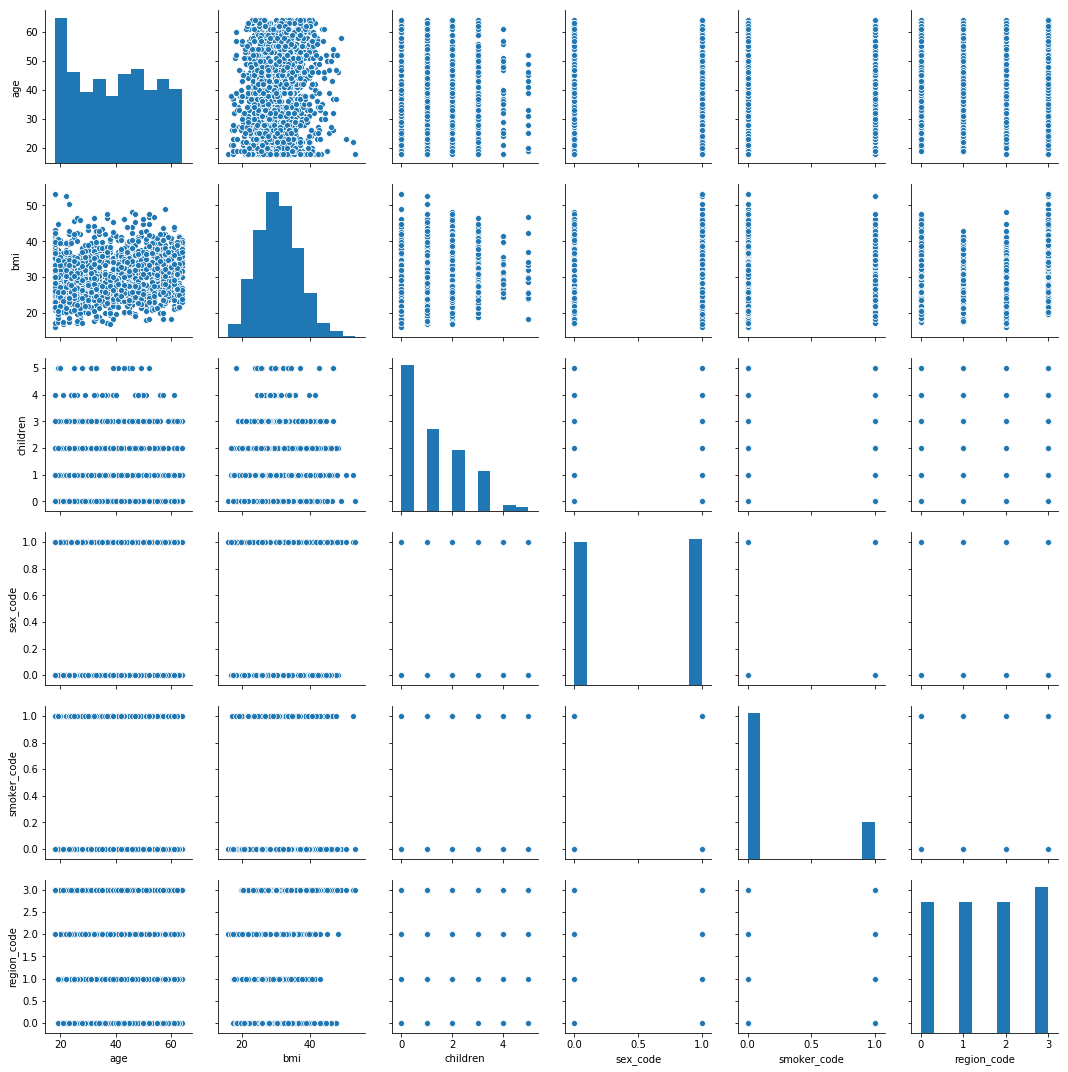

In [16]:
sb.pairplot(insurance_clean)

Is our data the normally distributed data set?

Next, we will perform the data visualization on the risk_level. Let's color code the data by the class.

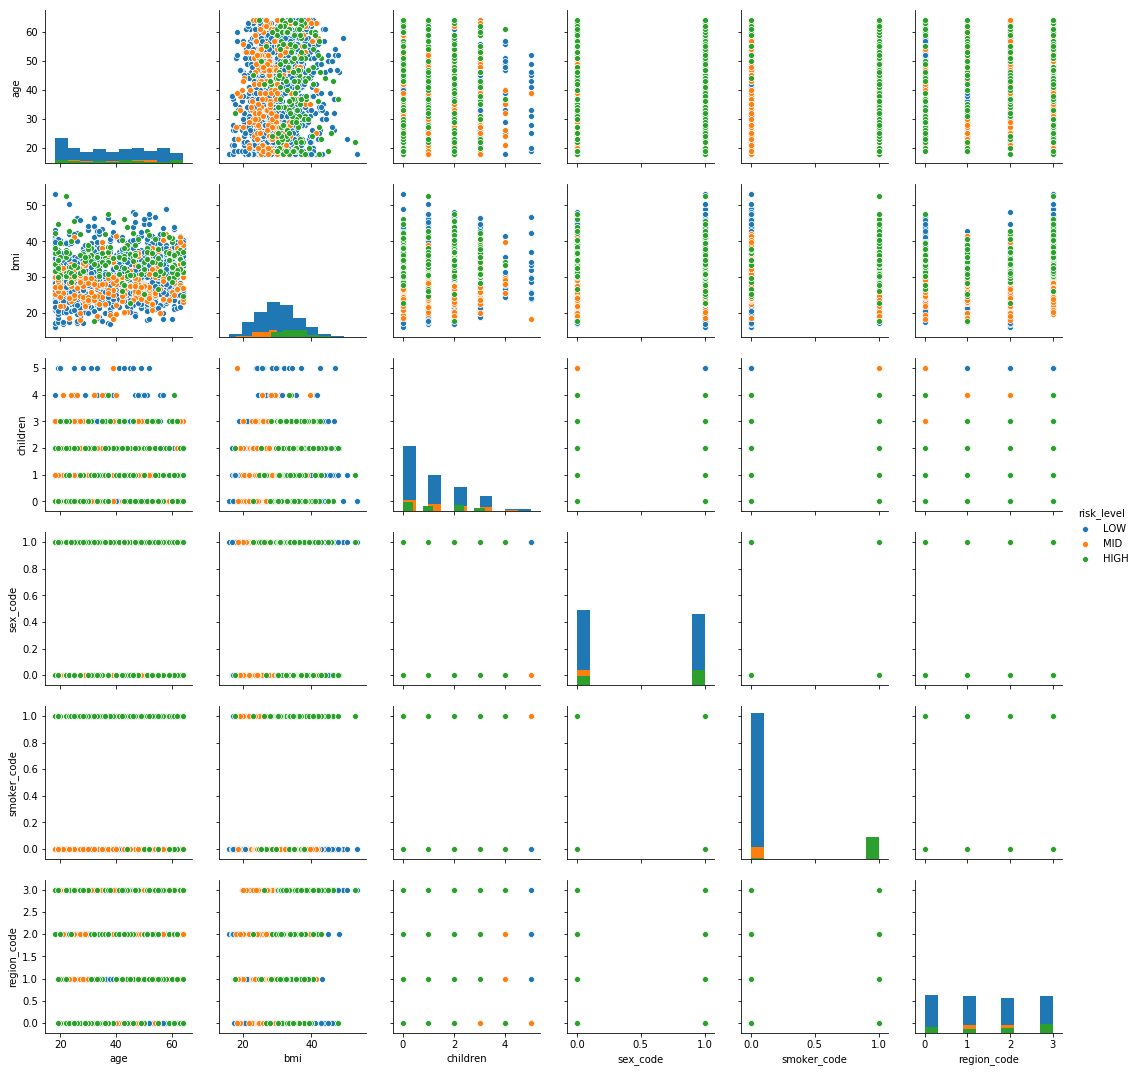

In [17]:
sb.pairplot(insurance_clean, hue="risk_level",diag_kind="hist")

Can you make out the different classes of the customer based on their features' values?

Is there any correlation between pair of features, etc? 

We can also make **violin plots** of the data to compare the measurement distributions of the classes. Violin plots contain the same information as [box plots](https://en.wikipedia.org/wiki/Box_plot), but also scales the box according to the density of the data.

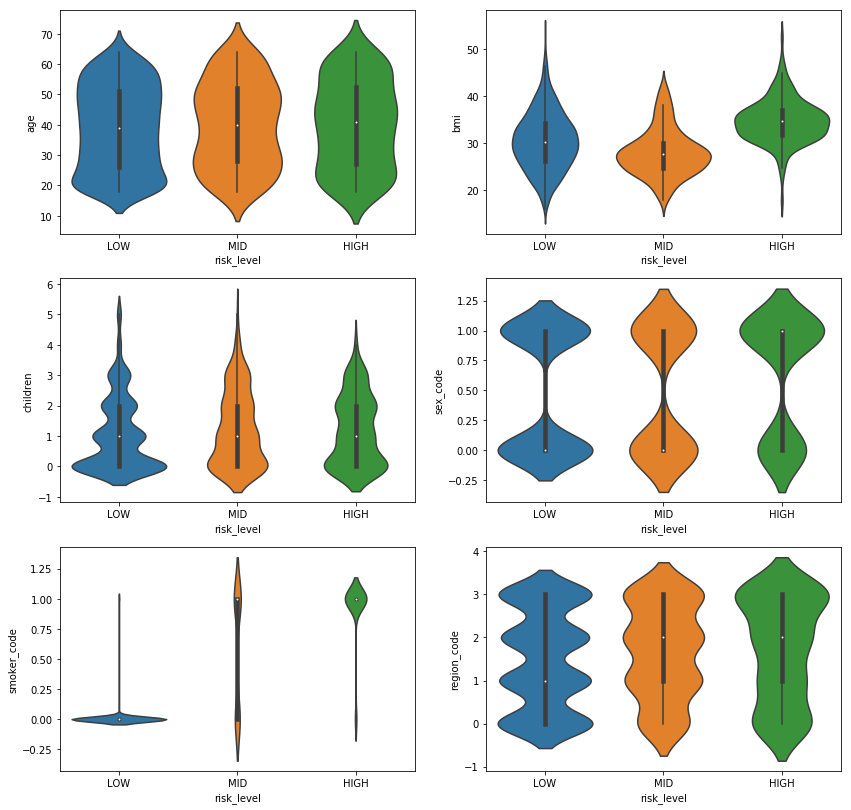

In [18]:
plt.figure(figsize=(14, 14))

for column_index, column in enumerate(insurance_clean.columns):
    if column == 'risk_level':
        continue
    plt.subplot(3, 2, column_index + 1)
    sb.violinplot(x='risk_level', y=column, data=insurance_clean)

## Step 5: Classification

After data preparation process, our data is assume to be cleaned. Next, we can create a classification model.

Remember: **Bad data leads to bad models.** Always check your data first.

<hr />

Supervised Learning Methodologies

A **training set** is a random subset of the data that we use to train our models. There is also a **tuning set** which is used to tune data. It is a subset of the training set.

A **testing set** is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforseen data.

Note that once we split the data into a training and testing set, we should treat the testing set like it no longer exists: We cannot use any information from the testing set to build our model or else we're cheating.

Let's set up our data first.

In [19]:
# We can extract the data in this format from pandas like this:
all_inputs = insurance_clean[['age', 'bmi', 'children', 'sex_code',
                             'smoker_code', 'region_code']]
# Similarly, we can extract the class labels
all_labels = insurance_clean['risk_level']

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_labels[5]

# Here's what a subset of our inputs looks like:
all_inputs[:5]

,age,bmi,children,sex_code,smoker_code,region_code
0,19,27.900,0,0,1,0
1,18,33.770,1,1,0,3
2,28,33.000,3,1,0,3
3,33,22.705,0,1,0,1
4,32,28.880,0,1,0,1


In [20]:
all_labels[:5]

0    MID
1    LOW
2    LOW
3    MID
4    LOW
Name: risk_level, dtype: category
Categories (3, object): [LOW < MID < HIGH]

Now our data is ready to be split.

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.3)
(train_inputs, tune_inputs, train_classes, tune_classes) = train_test_split(training_inputs, training_classes, test_size=0.25)

With our data split, we can fit models to our data, starting with one of the decision tree classifers.

There are several [parameters](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) that we can tune for decision tree classifiers, but for now let's use a basic decision tree classifier.

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(train_inputs, train_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(tune_inputs, tune_classes)

0.8632478632478633

The model achieves over 80% classification accuracy on the tuning data. While it is not our target, it still seems unrealistically simple. But, there's a catch: Depending on how our training and tuning set was sampled, our model's accuracy can vary:

(array([  3.,  18.,  40.,  87., 189., 249., 210., 140.,  57.,   7.]),
 array([0.79487179, 0.80811966, 0.82136752, 0.83461538, 0.84786325,
        0.86111111, 0.87435897, 0.88760684, 0.9008547 , 0.91410256,
        0.92735043]),
 <a list of 10 Patch objects>)

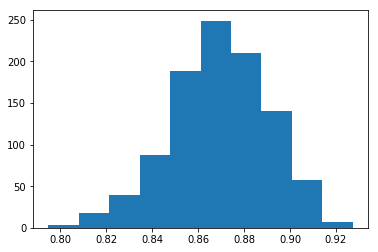

In [23]:
model_accuracies = []

for repetition in range(1000):
    (train_inputs,
     tune_inputs,
     train_classes,
     tune_classes) = train_test_split(training_inputs, training_classes, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(train_inputs, train_classes)
    classifier_accuracy = decision_tree_classifier.score(tune_inputs, tune_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)

It's a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as **overfitting**: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

### Cross-validation

This problem is the main reason that most data scientists perform ***k*-fold cross-validation** on their models: Split the original data set into *k* subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated *k* times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 10-fold cross-validation on our data set looks something like this:

(each square is an entry in our data set)

Text(0.5, 1.0, 'Average score: 0.8887218101204789')

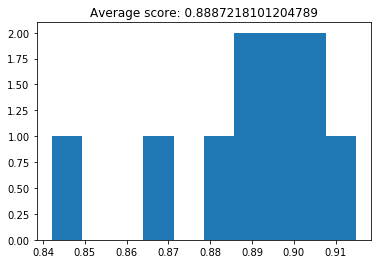

In [24]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, training_inputs, training_classes, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Now we have a much more consistent rating of our classifier's general classification accuracy.

### Parameter tuning

Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

Text(0.5, 1.0, 'Average score: 0.8490487909966197')

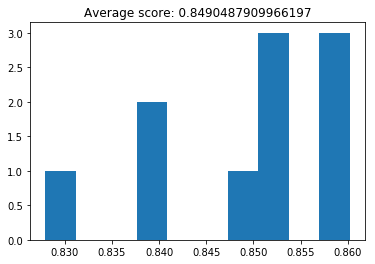

In [25]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, training_inputs, training_classes, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

The classification accuracy falls.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is **Grid Search**. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9197002141327623
Best parameters: {'max_depth': 5, 'max_features': 4}


Now let's visualize the grid search to see how the parameters interact.

''

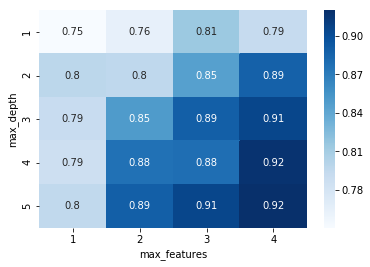

In [27]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

#### Now we have a better sense of the parameter space: We know that we need a `max_depth` of at least 3 and `max_feature` of at least 4 to allow the decision tree to make more than a one-off decision.

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [28]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9250535331905781
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'splitter': 'best'}


Now we can take the best classifier from the Grid Search and use that:

In [29]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, we can train and test our model with the best parameter.

In [30]:
decision_tree_classifier.fit(training_inputs, training_classes)

#testing using our holdout data
decision_tree_classifier.score(testing_inputs, testing_classes)

0.9052369077306733

We can even visualize the decision tree with [GraphViz](http://www.graphviz.org/) to see how it's making the classifications:

In [31]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO
from subprocess import check_call

with open('insurance_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)
    
#check_call(['dot','-Tpng','insurance_dtc.dot','-o','insurance_dtc.png'])

<img src="insurance_dtc.png" />

Alright! We finally have our demo classifier with over 90% accuracy. Let's create some visuals of its performance so we have something to show our company's Head of Data.

''

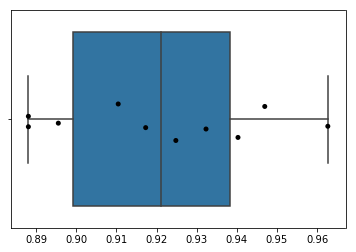

In [32]:
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)

sb.boxplot(dt_scores)
sb.stripplot(dt_scores, jitter=True, color='black')
;

Yes!!! Even though we used the same parameter setting from one fold of the data, we can perform over 90% on average. Our boss will be happy. How about we compare another classifier to see how they perform?


## Step 6: Reproducibility

Ensuring that our work is reproducible is the last and — arguably — most important step in any analysis. **As a rule, we shouldn't place much weight on a discovery that can't be reproduced**. As such, if our analysis isn't reproducible, we might as well not have done it.

Notebooks like this one go a long way toward making our work reproducible. Since we documented every step as we moved along, we have a written record of what we did and why we did it — both in text and code.

Beyond recording what we did, we should also document what software and hardware we used to perform our analysis. This typically goes at the top of our notebooks so our readers know what tools to use.

[Sebastian Raschka](http://sebastianraschka.com/) created a handy [notebook tool](https://github.com/rasbt/watermark) for this:

In [33]:
%load_ext watermark
%watermark -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn

Apirak Hoonlor Wed Nov 21 2018 

CPython 3.7.1
IPython 7.1.1

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.0
matplotlib 3.0.2
seaborn 0.9.0

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


Finally, let's extract the core of our work from Steps 1-5 and turn it into a single pipeline.

age	-->	LOW	(Actual: LOW)
bmi	-->	HIGH	(Actual: HIGH)
children	-->	LOW	(Actual: LOW)
sex_code	-->	MID	(Actual: MID)
smoker_code	-->	LOW	(Actual: LOW)
region_code	-->	LOW	(Actual: LOW)


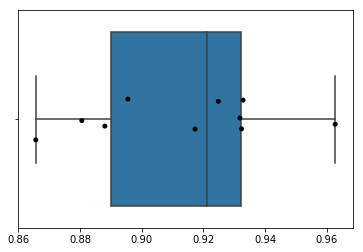

In [34]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import warnings

warnings.filterwarnings('ignore')
# We can jump directly to working with the clean data because we saved our cleaned data set
insurance_clean = pd.read_csv('../data/insurance_clean.csv')

# Testing our data: Our analysis will stop here if any of these assertions are wrong

# We know that we should only have three classes
assert len(insurance_clean['risk_level'].unique()) == 3

# We know that our data set should have no missing measurements
assert len(insurance_clean.loc[(insurance_clean['age'].isnull()) |
                               (insurance_clean['bmi'].isnull()) |
                               (insurance_clean['children'].isnull()) |
                               (insurance_clean['sex_code'].isnull()) |
                               (insurance_clean['smoker_code'].isnull()) |
                               (insurance_clean['region_code'].isnull())]) == 0

# We can extract the data in this format from pandas like this:
all_inputs = insurance_clean[['age', 'bmi', 'children', 'sex_code',
                             'smoker_code', 'region_code']]

# Similarly, we can extract the class labels
all_labels = insurance_clean['risk_level']

# Create the training and tuning parameters
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)


# Create decision tree classifier and find the best parameters
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)

decision_tree_classifier = grid_search.best_estimator_

decision_tree_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              decision_tree_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))
    

# All that's left to do now is plot the cross-validation scores
dt_classifier_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
sb.boxplot(dt_classifier_scores)
sb.stripplot(dt_classifier_scores, jitter=True, color='black')

There we have it: We have a complete and reproducible Machine Learning pipeline to demo our data analytics. We've met the success criteria that we set from the beginning (>90% accuracy), and our pipeline is flexible enough to handle new inputs or flowers when that data set is ready.

## Further reading

This notebook covers a broad variety of topics but skips over many of the specifics. If you're looking to dive deeper into a particular topic, here's some recommended reading.

**Data Science**: William Chen compiled a [list of free books](http://www.wzchen.com/data-science-books/) for newcomers to Data Science, ranging from the basics of R & Python to Machine Learning to interviews and advice from prominent data scientists.

**Machine Learning**: /r/MachineLearning has a useful [Wiki page](https://www.reddit.com/r/MachineLearning/wiki/index) containing links to online courses, books, data sets, etc. for Machine Learning. There's also a [curated list](https://github.com/josephmisiti/awesome-machine-learning) of Machine Learning frameworks, libraries, and software sorted by language.

**Unit testing**: Dive Into Python 3 has a [great walkthrough](http://www.diveintopython3.net/unit-testing.html) of unit testing in Python, how it works, and how it should be used

**pandas** has [several tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) covering its myriad features.

**scikit-learn** has a [bunch of tutorials](http://scikit-learn.org/stable/tutorial/index.html) for those looking to learn Machine Learning in Python. Andreas Mueller's [scikit-learn workshop materials](https://github.com/amueller/scipy_2015_sklearn_tutorial) are top-notch and freely available.

**matplotlib** has many [books, videos, and tutorials](http://matplotlib.org/resources/index.html) to teach plotting in Python.

**Seaborn** has a [basic tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial.html) covering most of the statistical plotting features.